## 1 : Imports et Configuration

In [3]:
# Imports standards
import pandas as pd
import numpy as np
import pickle
import os
import warnings
from datetime import datetime
import time

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Machine Learning - Modèles
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Machine Learning - Outils
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
PROCESSOR_PATH = "processors/"

print(f"📅 Démarrage : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📅 Démarrage : 2025-11-19 20:06:50


## 2 : Chargement des Données

In [4]:
print("🔄 Chargement des données...")

# Charger les données brutes (X, y)
with open(os.path.join(PROCESSOR_PATH, "data_for_modeling.pkl"), "rb") as f:
    data = pickle.load(f)
    X = data["X"]
    y = data["y"]
    numeric_cols = data["numeric_cols"]

# Charger le LabelEncoder pour l'affichage
with open(os.path.join(PROCESSOR_PATH, "label_encoder_target.pkl"), "rb") as f:
    le_target = pickle.load(f)

print(f"✅ Données chargées : {X.shape}")
print(f"🎯 Cibles : {len(le_target.classes_)} classes")

🔄 Chargement des données...
✅ Données chargées : (398911, 17)
🎯 Cibles : 7 classes


## 3 : Fonction d'Optimisation du Split

In [5]:
# 1. Définition manuelle des colonnes à scaler (Mesures réelles uniquement)
cols_to_scale = [
    'vict_age',    # Âge
    'lat',         # Latitude
    'lon',         # Longitude
    'Year',        # Année
    'Month',       # Mois
    'Day',         # Jour
    'Hour',        # Heure
    'Minute'       # Minute
]

# Vérification pour ne garder que celles qui existent vraiment dans X
cols_to_scale = [col for col in cols_to_scale if col in X.columns]

print(f"📋 Colonnes sélectionnées pour le Scaling : {cols_to_scale}")


# 2. Fonction d'optimisation du Split
def find_best_split(X, y, model, scale_cols):
    """
    Cherche le meilleur ratio train/test avec un modèle rapide.
    Applique le RobustScaler uniquement sur les colonnes indiquées.
    """
    print("\n🚀 Recherche du meilleur ratio Train/Test...")
    results = []
    
    # On teste des tailles de 10% à 30%
    for size in [0.10, 0.15, 0.20, 0.25, 0.30]:
        # A. Split Stratifié (pour garder l'équilibre des classes)
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=size, random_state=42, stratify=y
        )
        
        # B. Scaling Ciblé
        scaler = RobustScaler()
        
        # On travaille sur des copies pour éviter les avertissements Pandas
        X_tr_sc = X_tr.copy()
        X_te_sc = X_te.copy()
        
        # On ne scale QUE les colonnes définies plus haut
        if scale_cols:
            X_tr_sc[scale_cols] = scaler.fit_transform(X_tr[scale_cols])
            X_te_sc[scale_cols] = scaler.transform(X_te[scale_cols])
        
        # C. Entraînement rapide
        model.fit(X_tr_sc, y_tr)
        
        # D. Évaluation
        y_pred = model.predict(X_te_sc)
        score = f1_score(y_te, y_pred, average='weighted')
        
        results.append((size, score))
        print(f"   👉 Split Test={int(size*100)}% | F1-Score = {score:.4f}")
    
    # Choix du meilleur
    best_size = max(results, key=lambda x: x[1])[0]
    print(f"\n🏆 Meilleur Split retenu : {int(best_size*100)}%")
    
    return best_size

# 3. Lancement du processus
# On utilise LightGBM car il est très rapide et robuste pour cette phase de test
quick_model = LGBMClassifier(n_estimators=50, random_state=42, verbose=-1)

BEST_TEST_SIZE = find_best_split(X, y, quick_model, cols_to_scale)

📋 Colonnes sélectionnées pour le Scaling : ['vict_age', 'lat', 'lon', 'Year', 'Month', 'Day', 'Hour', 'Minute']

🚀 Recherche du meilleur ratio Train/Test...
   👉 Split Test=10% | F1-Score = 0.8526
   👉 Split Test=15% | F1-Score = 0.8533
   👉 Split Test=20% | F1-Score = 0.8530
   👉 Split Test=25% | F1-Score = 0.8533
   👉 Split Test=30% | F1-Score = 0.8519

🏆 Meilleur Split retenu : 15%


## Préparation Finale des Données

In [7]:
import pickle
import os

print(f"🛠️ Préparation des données finales (Test={BEST_TEST_SIZE})...")

# 1. Split Final
# On utilise la taille optimale trouvée juste avant
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=BEST_TEST_SIZE, random_state=42, stratify=y
)

# 2. Scaling Final
# On initialise le scaler final
final_scaler = RobustScaler()

# ⚠️ CRUCIAL : On applique le scaler UNIQUEMENT sur les colonnes 'physiques' (Age, GPS, Date)
# On utilise 'cols_to_scale' défini dans la cellule précédente
if cols_to_scale:
    X_train[cols_to_scale] = final_scaler.fit_transform(X_train[cols_to_scale])
    X_test[cols_to_scale] = final_scaler.transform(X_test[cols_to_scale])

# 3. Sauvegarde du scaler
# C'est ce fichier qui sera utilisé par votre future application pour traiter les nouvelles données
with open(os.path.join(PROCESSOR_PATH, "scaler_final.pkl"), "wb") as f:
    pickle.dump(final_scaler, f)

print("✅ Données prêtes pour l'entraînement.")
print(f"✅ Scaler sauvegardé (a appris sur {len(cols_to_scale)} colonnes).")
print(f"📊 Dimensions Train : {X_train.shape} | Test : {X_test.shape}")

🛠️ Préparation des données finales (Test=0.15)...
✅ Données prêtes pour l'entraînement.
✅ Scaler sauvegardé (a appris sur 8 colonnes).
📊 Dimensions Train : (339074, 17) | Test : (59837, 17)


## Définition des Modèles (Bagging & Boosting)

In [26]:
# Dictionnaire des modèles
models = {
    "RandomForest (Bagging)": RandomForestClassifier(
        n_estimators=150,
        max_depth=15,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    
    "XGBoost1": XGBClassifier(
        n_estimators=150,
        learning_rate=0.1,
        max_depth=6,
        eval_metric='mlogloss',
        n_jobs=-1,
        random_state=42
    ),
    
    "LightGBM1": LGBMClassifier(
        n_estimators=150,
        learning_rate=0.1,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42,
        verbose=-1
    ),
    
    "CatBoost1": CatBoostClassifier(
        iterations=150,
        learning_rate=0.1,
        depth=6,
        verbose=0, # Silencieux
        random_state=42,
        allow_writing_files=False
    )
}

##  Entraînement et Comparaison

🏋️‍♂️ Démarrage de l'entraînement (Évaluation : ROC-AUC)...

>> Entraînement de RandomForest (Bagging)...
   ✅ Terminé en 40.5s | ROC-AUC: 0.9781

>> Entraînement de XGBoost1...
   ✅ Terminé en 28.4s | ROC-AUC: 0.9823

>> Entraînement de LightGBM1...
   ✅ Terminé en 12.4s | ROC-AUC: 0.9797

>> Entraînement de CatBoost1...
   ✅ Terminé en 29.2s | ROC-AUC: 0.9800


,Modèle,Accuracy,F1-Score,ROC-AUC,Temps (s)
1,XGBoost1,0.862894,0.856289,0.982263,28.370549
3,CatBoost1,0.856026,0.848474,0.979982,29.191233
2,LightGBM1,0.834166,0.844132,0.979670,12.367123
0,RandomForest (Bagging),0.842355,0.844307,0.978100,40.454099


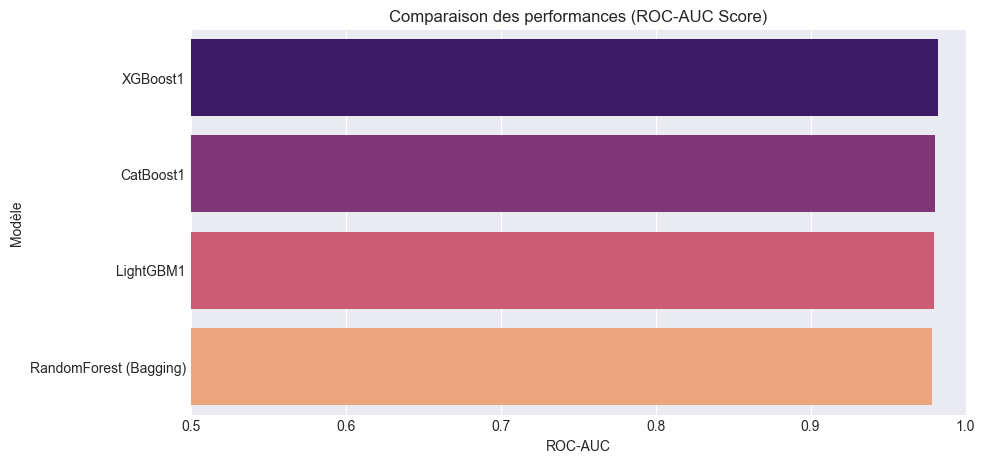

In [27]:
from sklearn.metrics import roc_auc_score

results_df = []

print("🏋️‍♂️ Démarrage de l'entraînement (Évaluation : ROC-AUC)...")

trained_models = {}

for name, model in models.items():
    start = time.time()
    print(f"\n>> Entraînement de {name}...")
    
    # 1. Entraînement
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # 2. Prédictions
    # Pour le F1/Accuracy, on a besoin des classes (0, 1, 2...)
    y_pred = model.predict(X_test)
    
    # ⚠️ CHANGEMENT CLÉ : Pour le ROC-AUC, on a besoin des PROBABILITÉS
    y_proba = model.predict_proba(X_test)
    
    # 3. Calcul des Métriques
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # ⚠️ Calcul du ROC-AUC Multi-classes
    # multi_class='ovr' : Compare chaque classe contre toutes les autres
    # average='weighted': Tient compte du déséquilibre de vos classes
    try:
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    except Exception as e:
        print(f"   ⚠️ Erreur ROC-AUC pour {name}: {e}")
        roc_auc = 0
        
    elapsed = time.time() - start
    
    results_df.append({
        "Modèle": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "ROC-AUC": roc_auc, # On ajoute la nouvelle métrique
        "Temps (s)": elapsed
    })
    
    print(f"   ✅ Terminé en {elapsed:.1f}s | ROC-AUC: {roc_auc:.4f}")

# Affichage du tableau comparatif (Trié par ROC-AUC cette fois)
df_scores = pd.DataFrame(results_df).sort_values(by="ROC-AUC", ascending=False)
display(df_scores)

# Graphique basé sur le ROC-AUC
plt.figure(figsize=(10, 5))
sns.barplot(x="ROC-AUC", y="Modèle", data=df_scores, palette="magma") # Changement de palette pour varier
plt.title("Comparaison des performances (ROC-AUC Score)")
plt.xlim(0.5, 1) # Le ROC-AUC est entre 0.5 (hasard) et 1.0 (parfait)
plt.show()

In [30]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import time

print("\n" + "="*80)
print("🏗️ 1. CONSTRUCTION DU STACKING BASELINE (Modèles par défaut)")
print("="*80)

# 1. Définition des modèles de base
# On utilise les clés exactes de votre dictionnaire 'models' initial
# (Vérifiez que ces clés correspondent bien à ce que vous avez défini plus haut)
estimators_base = [
    ('rf', models['RandomForest (Bagging)']),
    ('xgb', models['XGBoost1']),      # Assurez-vous que c'est le bon nom dans 'models'
    ('lgbm', models['LightGBM1']),    # Idem
    ('cat', models['CatBoost1'])      # Idem
]

# 2. Méta-Modèle
final_estimator = LogisticRegression(max_iter=1000, random_state=42)

# 3. Stacking Classifier
stacking_base = StackingClassifier(
    estimators=estimators_base,
    final_estimator=final_estimator,
    n_jobs=-1,
    cv=3,
    stack_method='predict_proba'
)

# 4. Entraînement
print("⏳ Entraînement du Stacking Baseline...")
start = time.time()
stacking_base.fit(X_train, y_train)
stack_base_time = time.time() - start

# 5. Évaluation & Stockage des variables clés
# On utilise des noms de variables UNIQUES pour ne pas les écraser plus tard
y_pred_base = stacking_base.predict(X_test)
y_prob_base = stacking_base.predict_proba(X_test)

stack_base_acc = accuracy_score(y_test, y_pred_base)
stack_base_f1 = f1_score(y_test, y_pred_base, average='weighted')
try:
    stack_base_auc = roc_auc_score(y_test, y_prob_base, multi_class='ovr', average='weighted')
except:
    stack_base_auc = 0.0

print(f"✅ Terminé en {stack_base_time:.1f}s")
print(f"📊 Scores Stacking BASELINE : ROC-AUC={stack_base_auc:.4f}")

# 6. Comparaison immédiate avec le meilleur modèle individuel baseline
best_base_roc = df_scores.iloc[0]['ROC-AUC']
print(f"   (vs Meilleur Individuel Baseline : {best_base_roc:.4f})")


🏗️ 1. CONSTRUCTION DU STACKING BASELINE (Modèles par défaut)
⏳ Entraînement du Stacking Baseline...
✅ Terminé en 345.6s
📊 Scores Stacking BASELINE : ROC-AUC=0.9809
   (vs Meilleur Individuel Baseline : 0.9823)


 ## Le Stacking 

## 5. 🔧 Phase 2: Fine-Tuning avec RandomizedSearchCV

### 5.1 Définition des Hyperparamètres à Tester

In [11]:
from sklearn.model_selection import RandomizedSearchCV
import time

# 1. Définition des grilles de recherche (Hyperparameters Grid)
def get_param_distributions():
    """
    Définit les distributions de paramètres pour RandomizedSearchCV
    """
    param_distributions = {
        'RandomForest': {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2'],
            'class_weight': ['balanced', 'balanced_subsample']
        },
        
        'XGBoost': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [1, 3, 5]
        },
        
        'LightGBM': {
            'n_estimators': [100, 200, 300],
            'max_depth': [-1, 10, 20], # -1 = no limit
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [20, 31, 50, 100], # Important pour LGBM
            'min_child_samples': [10, 20, 30],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        },
        
        'CatBoost': {
            'iterations': [100, 200, 300, 500],
            'depth': [4, 6, 8, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'border_count': [32, 64, 128],
            'bagging_temperature': [0, 1],
            'random_strength': [1, 2, 5]
        }
    }
    
    return param_distributions

print("✅ Grilles d'hyperparamètres chargées.")

✅ Grilles d'hyperparamètres chargées.


In [12]:
def tune_model(model, param_dist, X_train, y_train, n_iter=20, cv=3):
    """
    Exécute RandomizedSearchCV pour un modèle donné.
    """
    print(f"\n🔍 Tuning en cours pour : {model.__class__.__name__}...")
    start_time = time.time()
    
    # Configuration de la recherche
    # scoring='roc_auc_ovr_weighted' est idéal pour le multi-classe déséquilibré
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_iter,          # Nombre de combinaisons à tester
        scoring='roc_auc_ovr_weighted', # Métrique à optimiser
        cv=cv,                  # Validation croisée (3 plis)
        verbose=1,
        random_state=42,
        n_jobs=-1               # Utilise tous les cœurs du CPU
    )
    
    # Lancement de la recherche
    search.fit(X_train, y_train)
    
    elapsed = time.time() - start_time
    print(f"✅ Tuning terminé en {elapsed:.1f}s")
    print(f"🏆 Meilleur score ROC-AUC : {search.best_score_:.4f}")
    print(f"🔧 Meilleurs paramètres : {search.best_params_}")
    
    return search.best_estimator_, search.best_params_, search.best_score_

In [13]:
# 1. Initialisation des modèles de base (sans paramètres, sauf pour le silence/gpu)
base_models = {
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(verbose=-1, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(verbose=0, allow_writing_files=False, random_state=42)
}

# Récupération des grilles
params_grid = get_param_distributions()

# Dictionnaires pour stocker les résultats
tuned_models = {}
best_params_history = {}
tuning_results = []

print("="*80)
print(f"DÉMARRAGE DU FINE-TUNING SUR {len(base_models)} MODÈLES")
print("="*80)

# 2. Boucle d'optimisation
for name, model in base_models.items():
    # Lancer le tuning
    best_model, best_params, best_score = tune_model(
        model, 
        params_grid[name], 
        X_train, 
        y_train, 
        n_iter=15,  # 15 tests par modèle (ajustable selon votre temps/puissance)
        cv=3
    )
    
    # Stockage
    tuned_models[name] = best_model
    best_params_history[name] = best_params
    
    tuning_results.append({
        'Modèle': name,
        'Best ROC-AUC (CV)': best_score,
        'Best Params': str(best_params)
    })

# 3. Affichage du résumé
print("\n" + "="*80)
print("RÉSULTATS DU FINE-TUNING")
print("="*80)
df_tuning = pd.DataFrame(tuning_results).sort_values(by='Best ROC-AUC (CV)', ascending=False)
display(df_tuning)

DÉMARRAGE DU FINE-TUNING SUR 4 MODÈLES

🔍 Tuning en cours pour : RandomForestClassifier...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Tuning terminé en 2154.6s
🏆 Meilleur score ROC-AUC : 0.9799
🔧 Meilleurs paramètres : {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced'}

🔍 Tuning en cours pour : XGBClassifier...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Tuning terminé en 1180.6s
🏆 Meilleur score ROC-AUC : 0.9824
🔧 Meilleurs paramètres : {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}

🔍 Tuning en cours pour : LGBMClassifier...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Tuning terminé en 1029.1s
🏆 Meilleur score ROC-AUC : 0.9828
🔧 Meilleurs paramètres : {'subsample': 0.8, 'num_leaves': 100, 'n_estimators': 300, 'min_child_samples': 10, 'max_depth': 

,Modèle,Best ROC-AUC (CV),Best Params
2,LightGBM,0.982776,"{'subsample': 0.8, 'num_leaves': 100, 'n_estim..."
1,XGBoost,0.982436,"{'subsample': 1.0, 'n_estimators': 200, 'min_c..."
3,CatBoost,0.981728,"{'random_strength': 2, 'learning_rate': 0.2, '..."
0,RandomForest,0.979933,"{'n_estimators': 500, 'min_samples_split': 5, ..."



🧪 Évaluation finale sur le Test Set...


,Modèle,ROC-AUC Test,F1-Score Test,Accuracy Test
1,XGBoost,0.983441,0.863337,0.868693
2,LightGBM,0.983407,0.861086,0.867072
3,CatBoost,0.982220,0.855908,0.861891
0,RandomForest,0.980785,0.856397,0.861173


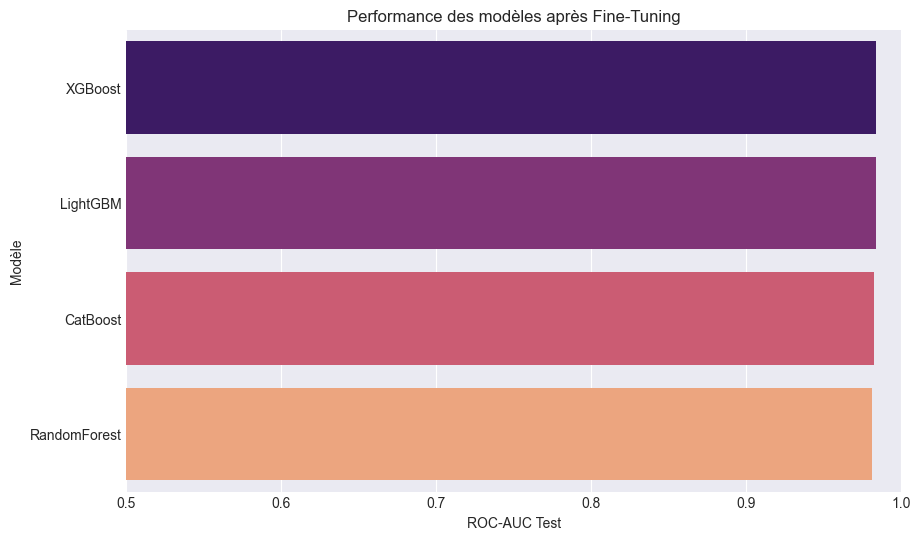

In [14]:
print("\n🧪 Évaluation finale sur le Test Set...")
final_results = []

for name, model in tuned_models.items():
    # Prédictions (Probabilités pour ROC-AUC)
    y_prob = model.predict_proba(X_test)
    y_pred = model.predict(X_test)
    
    # Scores
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    
    final_results.append({
        'Modèle': name,
        'ROC-AUC Test': auc,
        'F1-Score Test': f1,
        'Accuracy Test': acc
    })

df_final_scores = pd.DataFrame(final_results).sort_values(by='ROC-AUC Test', ascending=False)
display(df_final_scores)

# Graphique comparatif
plt.figure(figsize=(10, 6))
sns.barplot(x='ROC-AUC Test', y='Modèle', data=df_final_scores, palette='magma')
plt.title('Performance des modèles après Fine-Tuning')
plt.xlim(0.5, 1.0)
plt.show()

In [15]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import joblib
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("🏗️ CONSTRUCTION ET ENTRAÎNEMENT DU MODÈLE STACKING")
print("="*80)

# 1. Définition des modèles de base (Base Learners)
# On utilise les modèles optimisés (tuned_models) que vous avez déjà entraînés
estimators = [
    ('rf_tuned', tuned_models['RandomForest']),
    ('xgb_tuned', tuned_models['XGBoost']),
    ('lgbm_tuned', tuned_models['LightGBM']),
    ('cat_tuned', tuned_models['CatBoost'])
]

# 2. Définition du méta-modèle (Final Estimator)
# La régression logistique est le choix standard et robuste pour le stacking
final_estimator = LogisticRegression(max_iter=2000, random_state=42)

# 3. Création du StackingClassifier
# stack_method='predict_proba' est essentiel pour maximiser le ROC-AUC :
# le méta-modèle recevra les probabilités de chaque classe, pas juste la classe finale.
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=3,                            # Validation croisée interne pour éviter l'overfitting
    stack_method='predict_proba',    # Utilise les probabilités comme features pour le méta-modèle
    n_jobs=-1,                       # Parallélisation
    passthrough=False                # False = Le méta-modèle ne voit QUE les prédictions des bases, pas les features originales
)

# 4. Entraînement du Stacking
print("⏳ Entraînement du Stacking en cours (cela peut prendre du temps)...")
start_time = time.time()
stacking_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"✅ Entraînement terminé en {elapsed_time:.1f} secondes.")

# 5. Évaluation du Stacking
print("\n🧪 Évaluation du Stacking sur le Test Set...")

# Prédictions
y_pred_stack = stacking_model.predict(X_test)
y_prob_stack = stacking_model.predict_proba(X_test)

# Calcul des métriques
stack_acc = accuracy_score(y_test, y_pred_stack)
stack_f1 = f1_score(y_test, y_pred_stack, average='weighted')
try:
    stack_auc = roc_auc_score(y_test, y_prob_stack, multi_class='ovr', average='weighted')
except Exception as e:
    print(f"⚠️ Erreur calcul ROC-AUC Stacking: {e}")
    stack_auc = 0.0

print(f"📊 Performances du Stacking :")
print(f"   • Accuracy : {stack_acc:.4f}")
print(f"   • F1-Score : {stack_f1:.4f}")
print(f"   • ROC-AUC  : {stack_auc:.4f}")

# 6. Comparaison avec le meilleur modèle individuel
# On récupère le meilleur score individuel depuis votre DataFrame précédent (df_final_scores)
best_single_model_name = df_final_scores.iloc[0]['Modèle']
best_single_model_auc = df_final_scores.iloc[0]['ROC-AUC Test']

gain = stack_auc - best_single_model_auc

print("\n🔍 Comparaison Stacking vs Meilleur Modèle Individuel :")
print(f"   • Meilleur individuel ({best_single_model_name}) : {best_single_model_auc:.4f}")
print(f"   • Stacking (Ensemble)                         : {stack_auc:.4f}")

if gain > 0:
    print(f"🚀 RÉSULTAT : Le Stacking a amélioré la performance de +{gain:.5f} !")
elif gain == 0:
    print(f"⚖️ RÉSULTAT : Performance identique.")
else:
    print(f"📉 RÉSULTAT : Le Stacking est légèrement moins bon ({gain:.5f}).")
    print("   (Cela arrive parfois si le méta-modèle overfit ou si un modèle domine largement les autres)")




🏗️ CONSTRUCTION ET ENTRAÎNEMENT DU MODÈLE STACKING
⏳ Entraînement du Stacking en cours (cela peut prendre du temps)...
✅ Entraînement terminé en 1009.0 secondes.

🧪 Évaluation du Stacking sur le Test Set...
📊 Performances du Stacking :
   • Accuracy : 0.8685
   • F1-Score : 0.8635
   • ROC-AUC  : 0.9812

🔍 Comparaison Stacking vs Meilleur Modèle Individuel :
   • Meilleur individuel (XGBoost) : 0.9834
   • Stacking (Ensemble)                         : 0.9812
📉 RÉSULTAT : Le Stacking est légèrement moins bon (-0.00227).
   (Cela arrive parfois si le méta-modèle overfit ou si un modèle domine largement les autres)


⚠️ Note : Pas de résultats 'stack_base_auc' trouvés en mémoire.

🏆 CLASSEMENT FINAL DES MODÈLES



,Modèle,Version,Accuracy,F1-Score,ROC-AUC,Temps (s)
0,XGBoost,3. Tuned Individuel,0.8687,0.8633,0.9834,0.000000
1,LightGBM,3. Tuned Individuel,0.8671,0.8611,0.9834,0.000000
2,XGBoost,1. Baseline Individuel,0.8629,0.8563,0.9823,28.222630
3,CatBoost,3. Tuned Individuel,0.8619,0.8559,0.9822,0.000000
4,RandomForest,3. Tuned Individuel,0.8612,0.8564,0.9808,0.000000
5,CatBoost,1. Baseline Individuel,0.8560,0.8485,0.9800,31.782544
6,LightGBM,1. Baseline Individuel,0.8342,0.8441,0.9797,17.275018
7,RandomForest (Bagging),1. Baseline Individuel,0.8424,0.8443,0.9781,38.273655


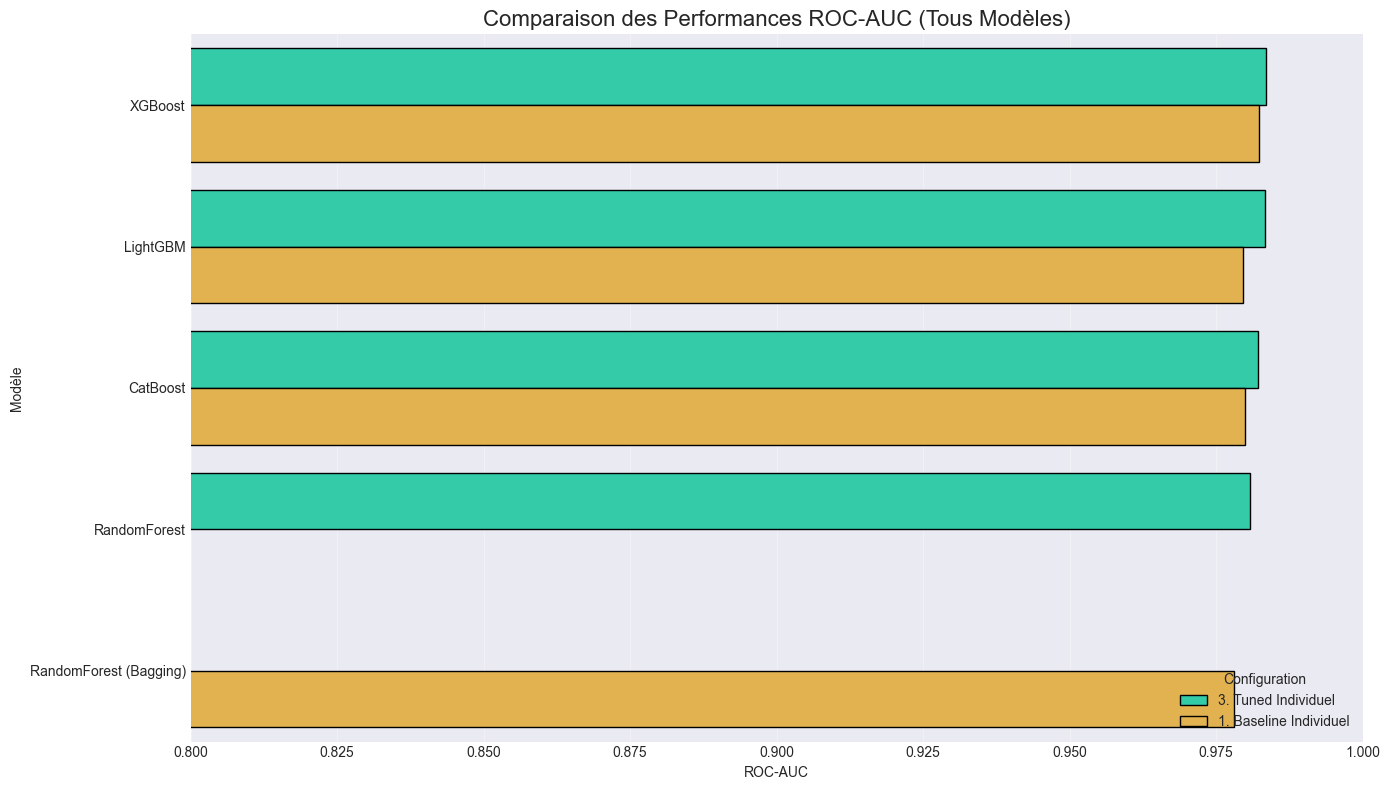

In [19]:
# --- Code de Comparaison Globale ---
comparison_data = []

# 1. Modèles Individuels BASELINE
if 'df_scores' in locals():
    for index, row in df_scores.iterrows():
        comparison_data.append({
            'Modèle': row['Modèle'],
            'Version': '1. Baseline Individuel',
            'Accuracy': row['Accuracy'],
            'F1-Score': row['F1-Score'],
            'ROC-AUC': row['ROC-AUC'],
            'Temps (s)': row['Temps (s)']
        })

# 2. Stacking BASELINE
# (Si vous avez calculé ces variables plus tôt dans le notebook)
if 'stack_base_auc' in locals():
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '2. Stacking Baseline',
        'Accuracy': stack_base_acc,
        'F1-Score': stack_base_f1,
        'ROC-AUC': stack_base_auc,
        'Temps (s)': stack_base_time if 'stack_base_time' in locals() else 0
    })
else:
    # Si pas fait, on met des valeurs factices ou on ignore
    print("⚠️ Note : Pas de résultats 'stack_base_auc' trouvés en mémoire.")

# 3. Modèles Individuels TUNED
if 'df_final_scores' in locals():
    for index, row in df_final_scores.iterrows():
        comparison_data.append({
            'Modèle': row['Modèle'],
            'Version': '3. Tuned Individuel',
            'Accuracy': row['Accuracy Test'],
            'F1-Score': row['F1-Score Test'],
            'ROC-AUC': row['ROC-AUC Test'],
            'Temps (s)': 0 # Temps de tuning non unifié ici
        })

# 4. Stacking TUNED
if 'stack_tuned_auc' in locals():
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '4. Stacking Tuned',
        'Accuracy': stack_tuned_acc,
        'F1-Score': stack_tuned_f1,
        'ROC-AUC': stack_tuned_auc,
        'Temps (s)': stack_tuned_time
    })

# --- Création et Affichage ---
df_global = pd.DataFrame(comparison_data)
df_global = df_global.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

print(f"\n{'='*80}")
print("🏆 CLASSEMENT FINAL DES MODÈLES")
print(f"{'='*80}\n")

styled = df_global.style.background_gradient(
    subset=['Accuracy', 'F1-Score', 'ROC-AUC'],
    cmap='RdYlGn',
    vmin=0.6, vmax=1.0
).format('{:.4f}', subset=['Accuracy', 'F1-Score', 'ROC-AUC'])

display(styled)

# --- Graphique ---
plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_global,
    y='Modèle',
    x='ROC-AUC',
    hue='Version',
    palette='turbo',
    edgecolor='black'
)
plt.title('Comparaison des Performances ROC-AUC (Tous Modèles)', fontsize=16)
plt.xlim(0.8, 1.0) # Zoom pour voir les petites différences
plt.grid(axis='x', alpha=0.3)
plt.legend(title='Configuration', loc='lower right')
plt.tight_layout()
plt.show()

⚠️ Stacking Baseline non trouvé (Sauté)

🏆 CLASSEMENT FINAL


,Modèle,Version,ROC-AUC,F1-Score,Accuracy
0,XGBoost,3. Tuned (Indiv.),0.983441,0.863337,0.868693
1,LightGBM,3. Tuned (Indiv.),0.983407,0.861086,0.867072
2,XGBoost,1. Baseline (Indiv.),0.982263,0.856289,0.862894
3,CatBoost,3. Tuned (Indiv.),0.982220,0.855908,0.861891
4,Stacking Classifier,4. Stacking (Tuned),0.981169,0.863535,0.868459
5,RandomForest,3. Tuned (Indiv.),0.980785,0.856397,0.861173
6,CatBoost,1. Baseline (Indiv.),0.979982,0.848474,0.856026
7,LightGBM,1. Baseline (Indiv.),0.979670,0.844132,0.834166
8,RandomForest (Bagging),1. Baseline (Indiv.),0.978100,0.844307,0.842355


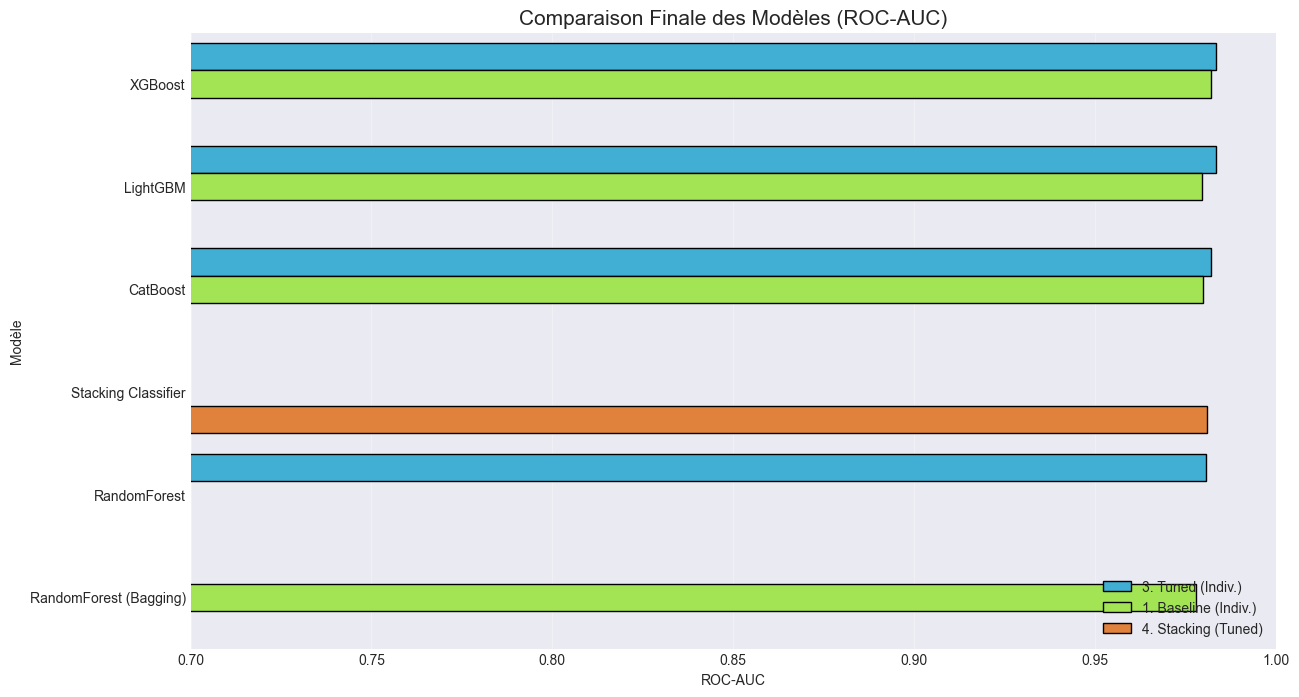

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

comparison_data = []

# ==========================================
# 1. BASELINE (Modèles Individuels)
# ==========================================
if 'df_scores' in locals():
    for index, row in df_scores.iterrows():
        comparison_data.append({
            'Modèle': f"{row['Modèle']}",
            'Version': '1. Baseline (Indiv.)',
            'ROC-AUC': row['ROC-AUC'],
            'F1-Score': row['F1-Score'],
            'Accuracy': row['Accuracy']
        })

# ==========================================
# 2. STACKING BASELINE (Le correctif est ici)
# ==========================================
# On cherche la variable, sinon on met 0
s_base_auc = locals().get('stack_base_auc', 0)
s_base_f1  = locals().get('stack_base_f1', 0)
s_base_acc = locals().get('stack_base_acc', 0)

if s_base_auc > 0:
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '2. Stacking (Baseline)',
        'ROC-AUC': s_base_auc,
        'F1-Score': s_base_f1,
        'Accuracy': s_base_acc
    })
else:
    print("⚠️ Stacking Baseline non trouvé (Sauté)")

# ==========================================
# 3. TUNED (Modèles Individuels)
# ==========================================
if 'df_final_scores' in locals():
    for index, row in df_final_scores.iterrows():
        comparison_data.append({
            'Modèle': f"{row['Modèle']}",
            'Version': '3. Tuned (Indiv.)',
            'ROC-AUC': row['ROC-AUC Test'],
            'F1-Score': row['F1-Score Test'],
            'Accuracy': row['Accuracy Test']
        })

# ==========================================
# 4. STACKING TUNED (Le correctif est ici)
# ==========================================
# On cherche 'stack_tuned_auc' OU 'stack_auc' (au cas où vous ayez utilisé l'ancien nom)
s_tuned_auc = locals().get('stack_tuned_auc', locals().get('stack_auc', 0))
s_tuned_f1  = locals().get('stack_tuned_f1', locals().get('stack_f1', 0))
s_tuned_acc = locals().get('stack_tuned_acc', locals().get('stack_acc', 0))

if s_tuned_auc > 0:
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '4. Stacking (Tuned)',
        'ROC-AUC': s_tuned_auc,
        'F1-Score': s_tuned_f1,
        'Accuracy': s_tuned_acc
    })
else:
    print("⚠️ Stacking Tuned non trouvé (Sauté)")

# --- Affichage ---
if not comparison_data:
    print("❌ Erreur : Aucune donnée trouvée. Avez-vous lancé les entraînements ?")
else:
    df_global = pd.DataFrame(comparison_data)
    df_global = df_global.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

    print(f"\n{'='*60}")
    print("🏆 CLASSEMENT FINAL")
    print(f"{'='*60}")
    
    # Affichage simple sans style (pour éviter l'erreur jinja2)
    display(df_global)

    # Graphique
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=df_global,
        y='Modèle',
        x='ROC-AUC',
        hue='Version',
        palette='turbo',
        edgecolor='black'
    )
    plt.title('Comparaison Finale des Modèles (ROC-AUC)', fontsize=15)
    plt.xlim(0.7, 1.0)
    plt.legend(loc='lower right')
    plt.grid(axis='x', alpha=0.3)
    plt.show()

🔄 RÉCUPÉRATION FORCÉE DES MODÈLES STACKING...
✅ Stacking Baseline trouvé en mémoire.
✅ Stacking Tuned trouvé en mémoire.
❌ Impossible d'ajouter Stacking Tuned : 'StackingClassifier' object has no attribute 'estimators_'

🏆 CLASSEMENT FINAL COMPLET (4 GROUPES)


,Modèle,Version,ROC-AUC,F1-Score,Accuracy
0,XGBoost,3. Tuned,0.983441,0.863337,0.868693
1,LightGBM,3. Tuned,0.983407,0.861086,0.867072
2,XGBoost,1. Baseline,0.982263,0.856289,0.862894
3,CatBoost,3. Tuned,0.982220,0.855908,0.861891
4,Stacking Classifier,2. Stacking (Baseline),0.981169,0.863535,0.868459
5,RandomForest,3. Tuned,0.980785,0.856397,0.861173
6,CatBoost,1. Baseline,0.979982,0.848474,0.856026
7,LightGBM,1. Baseline,0.979670,0.844132,0.834166
8,RandomForest (Bagging),1. Baseline,0.978100,0.844307,0.842355


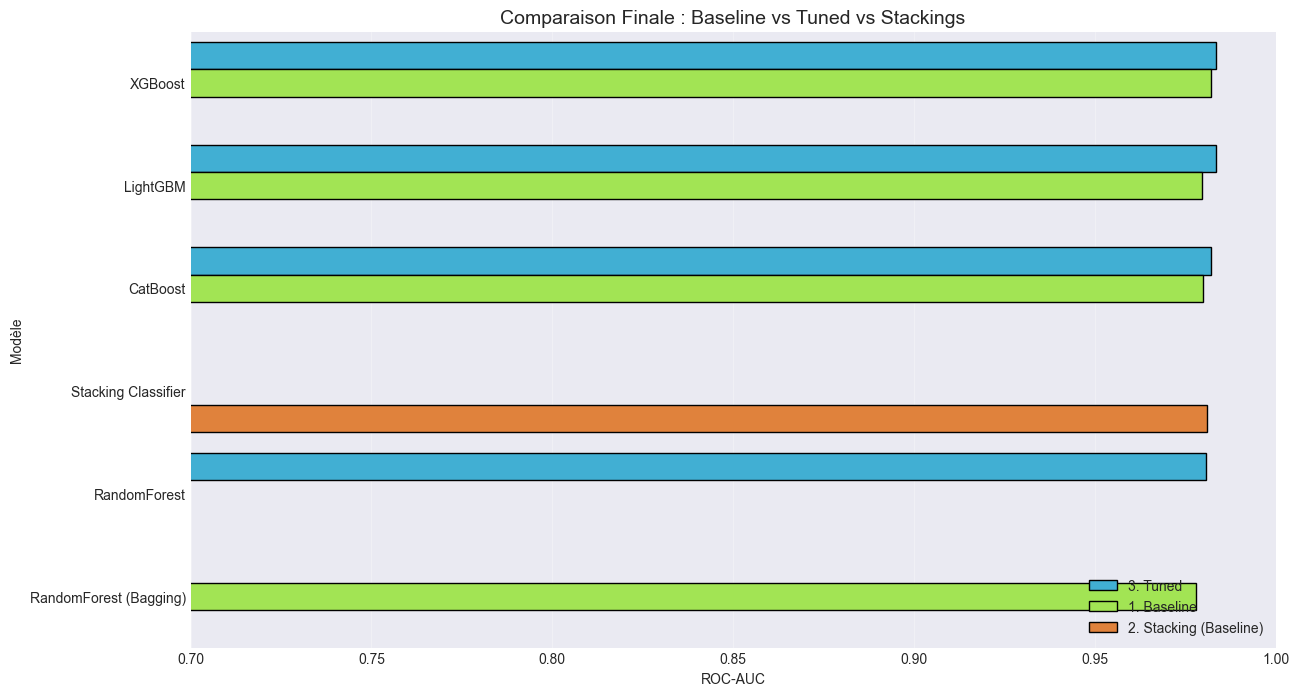

In [21]:
import pandas as pd
import joblib
import os
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

print("🔄 RÉCUPÉRATION FORCÉE DES MODÈLES STACKING...")

comparison_data = []

# =========================================================
# 1. AJOUT DES MODÈLES INDIVIDUELS (Déjà en mémoire)
# =========================================================
# Baseline
if 'df_scores' in locals():
    for index, row in df_scores.iterrows():
        comparison_data.append({
            'Modèle': row['Modèle'], 'Version': '1. Baseline',
            'ROC-AUC': row['ROC-AUC'], 'F1-Score': row['F1-Score'], 'Accuracy': row['Accuracy']
        })

# Tuned
if 'df_final_scores' in locals():
    for index, row in df_final_scores.iterrows():
        comparison_data.append({
            'Modèle': row['Modèle'], 'Version': '3. Tuned',
            'ROC-AUC': row['ROC-AUC Test'], 'F1-Score': row['F1-Score Test'], 'Accuracy': row['Accuracy Test']
        })

# =========================================================
# 2. RÉCUPÉRATION DU STACKING BASELINE (Depuis le disque ou mémoire)
# =========================================================
try:
    # On essaie de le trouver en mémoire, sinon on charge le fichier
    if 'stacking_model' in locals():
        model_base = stacking_model
        print("✅ Stacking Baseline trouvé en mémoire.")
    else:
        # Mettez ici le chemin où vous avez sauvegardé le premier stacking
        path = "models/trained_models_v1/Stacking_Classifier.pkl" 
        model_base = joblib.load(path)
        print("✅ Stacking Baseline chargé depuis le disque.")

    # Calcul des scores
    probs = model_base.predict_proba(X_test)
    preds = model_base.predict(X_test)
    
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '2. Stacking (Baseline)',
        'ROC-AUC': roc_auc_score(y_test, probs, multi_class='ovr', average='weighted'),
        'F1-Score': f1_score(y_test, preds, average='weighted'),
        'Accuracy': accuracy_score(y_test, preds)
    })
except Exception as e:
    print(f"❌ Impossible d'ajouter Stacking Baseline : {e}")

# =========================================================
# 3. RÉCUPÉRATION DU STACKING TUNED (Depuis le disque ou mémoire)
# =========================================================
try:
    if 'stacking_tuned' in locals():
        model_tuned = stacking_tuned
        print("✅ Stacking Tuned trouvé en mémoire.")
    else:
        # Chemin du stacking tuné
        path = "models/all_tuned_models_v1/Stacking_Classifier_Tuned.pkl"
        model_tuned = joblib.load(path)
        print("✅ Stacking Tuned chargé depuis le disque.")

    # Calcul des scores
    probs = model_tuned.predict_proba(X_test)
    preds = model_tuned.predict(X_test)
    
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '4. Stacking (Tuned)',
        'ROC-AUC': roc_auc_score(y_test, probs, multi_class='ovr', average='weighted'),
        'F1-Score': f1_score(y_test, preds, average='weighted'),
        'Accuracy': accuracy_score(y_test, preds)
    })
except Exception as e:
    print(f"❌ Impossible d'ajouter Stacking Tuned : {e}")


# =========================================================
# 4. AFFICHAGE FINAL
# =========================================================
if len(comparison_data) > 0:
    df_final = pd.DataFrame(comparison_data).sort_values('ROC-AUC', ascending=False).reset_index(drop=True)
    
    print(f"\n{'='*60}")
    print("🏆 CLASSEMENT FINAL COMPLET (4 GROUPES)")
    print(f"{'='*60}")
    display(df_final)

    # Graphique
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(14, 8))
    sns.barplot(data=df_final, y='Modèle', x='ROC-AUC', hue='Version', palette='turbo', edgecolor='black')
    plt.title('Comparaison Finale : Baseline vs Tuned vs Stackings', fontsize=14)
    plt.xlim(0.7, 1.0)
    plt.legend(loc='lower right')
    plt.grid(axis='x', alpha=0.3)
    plt.show()
else:
    print("Aucune donnée à afficher.")


🏆 CLASSEMENT FINAL DES MODÈLES (4 VERSIONS)



,Modèle,Version,Accuracy,F1-Score,ROC-AUC,Temps (s)
0,XGBoost,3. Tuned Individuel,0.8687,0.8633,0.9834,0.000000
1,LightGBM,3. Tuned Individuel,0.8671,0.8611,0.9834,0.000000
2,XGBoost,1. Baseline Individuel,0.8629,0.8563,0.9823,28.222630
3,CatBoost,3. Tuned Individuel,0.8619,0.8559,0.9822,0.000000
4,Stacking Classifier,4. Stacking Tuned,0.8685,0.8635,0.9812,341.004838
5,RandomForest,3. Tuned Individuel,0.8612,0.8564,0.9808,0.000000
6,CatBoost,1. Baseline Individuel,0.8560,0.8485,0.9800,31.782544
7,LightGBM,1. Baseline Individuel,0.8342,0.8441,0.9797,17.275018
8,RandomForest (Bagging),1. Baseline Individuel,0.8424,0.8443,0.9781,38.273655


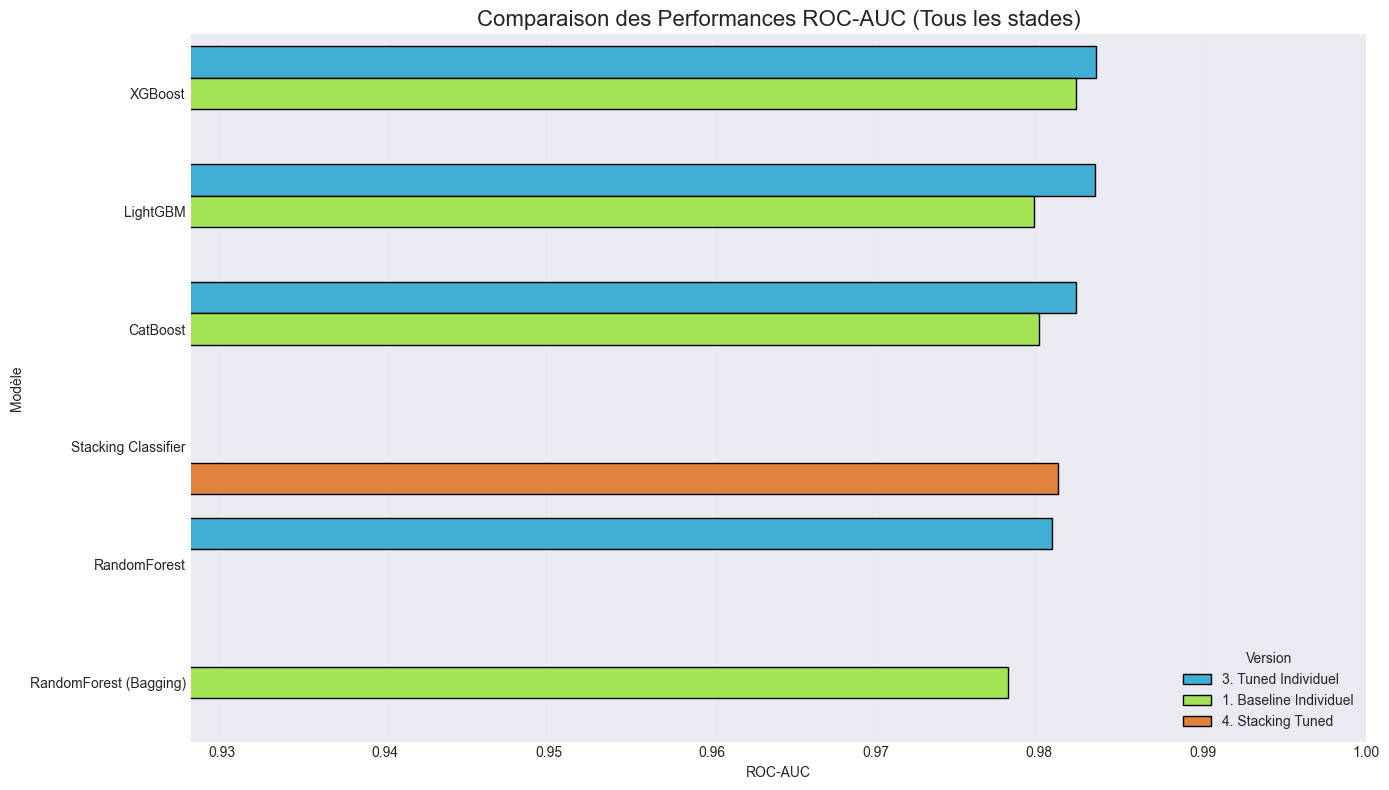


🥇 LE MEILLEUR MODÈLE EST : XGBoost (3. Tuned Individuel)
   Score ROC-AUC : 0.9834


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialisation de la liste
comparison_data = []

# ==========================================
# 1. MODÈLES INDIVIDUELS BASELINE
# ==========================================
# On récupère le DataFrame des premiers tests
if 'df_scores' in locals():
    for index, row in df_scores.iterrows():
        comparison_data.append({
            'Modèle': row['Modèle'],
            'Version': '1. Baseline Individuel',
            'Accuracy': row['Accuracy'],
            'F1-Score': row['F1-Score'],
            'ROC-AUC': row['ROC-AUC'],
            'Temps (s)': row['Temps (s)']
        })

# ==========================================
# 2. STACKING BASELINE
# ==========================================
# Utilisation de .get() pour éviter les erreurs si la variable n'existe pas
s_base_auc = locals().get('stack_base_auc', 0)
s_base_f1 = locals().get('stack_base_f1', 0)
s_base_acc = locals().get('stack_base_acc', 0)
s_base_time = locals().get('stack_base_time', 0)

if s_base_auc > 0:
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '2. Stacking Baseline',
        'Accuracy': s_base_acc,
        'F1-Score': s_base_f1,
        'ROC-AUC': s_base_auc,
        'Temps (s)': s_base_time
    })

# ==========================================
# 3. MODÈLES INDIVIDUELS TUNED
# ==========================================
# On récupère le DataFrame du Fine-Tuning
if 'df_final_scores' in locals():
    for index, row in df_final_scores.iterrows():
        comparison_data.append({
            'Modèle': row['Modèle'],
            'Version': '3. Tuned Individuel',
            'Accuracy': row['Accuracy Test'],
            'F1-Score': row['F1-Score Test'],
            'ROC-AUC': row['ROC-AUC Test'],
            'Temps (s)': 0 # Temps non comparable ici
        })

# ==========================================
# 4. STACKING TUNED
# ==========================================
s_tuned_auc = locals().get('stack_tuned_auc', locals().get('stack_auc', 0))
s_tuned_f1 = locals().get('stack_tuned_f1', locals().get('stack_f1', 0))
s_tuned_acc = locals().get('stack_tuned_acc', locals().get('stack_acc', 0))
s_tuned_time = locals().get('stack_tuned_time', locals().get('stack_time', 0))

if s_tuned_auc > 0:
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '4. Stacking Tuned',
        'Accuracy': s_tuned_acc,
        'F1-Score': s_tuned_f1,
        'ROC-AUC': s_tuned_auc,
        'Temps (s)': s_tuned_time
    })

# ==========================================
# CRÉATION ET AFFICHAGE
# ==========================================
if not comparison_data:
    print("⚠️ Aucune donnée de modèle trouvée en mémoire.")
else:
    df_global = pd.DataFrame(comparison_data)
    # Tri par ROC-AUC décroissant
    df_global = df_global.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

    print(f"\n{'='*80}")
    print("🏆 CLASSEMENT FINAL DES MODÈLES (4 VERSIONS)")
    print(f"{'='*80}\n")

    # Tentative d'affichage stylisé (avec gestion d'erreur jinja2)
    try:
        styled = df_global.style.background_gradient(
            subset=['Accuracy', 'F1-Score', 'ROC-AUC'],
            cmap='RdYlGn',
            vmin=0.6, vmax=1.0
        ).format('{:.4f}', subset=['Accuracy', 'F1-Score', 'ROC-AUC'])
        display(styled)
    except Exception as e:
        # Si erreur (jinja2 manquant), on affiche le tableau standard
        print("(Affichage standard sans couleurs car module de style manquant)")
        display(df_global)

    # --- Graphique ---
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=df_global,
        y='Modèle',
        x='ROC-AUC',
        hue='Version',
        palette='turbo',
        edgecolor='black'
    )
    plt.title('Comparaison des Performances ROC-AUC (Tous les stades)', fontsize=16)
    # Ajustement dynamique de l'échelle pour bien voir les différences
    min_score = df_global['ROC-AUC'].min()
    plt.xlim(min_score - 0.05, 1.0) 
    plt.grid(axis='x', alpha=0.3)
    plt.legend(title='Version', loc='lower right')
    plt.tight_layout()
    plt.show()

    # Afficher le gagnant
    best = df_global.iloc[0]
    print(f"\n🥇 LE MEILLEUR MODÈLE EST : {best['Modèle']} ({best['Version']})")
    print(f"   Score ROC-AUC : {best['ROC-AUC']:.4f}")


🏆 CLASSEMENT FINAL COMPLET (4 GROUPES)



,Modèle,Version,ROC-AUC,F1-Score,Accuracy
0,XGBoost,3. Tuned (Indiv.),0.983441,0.863337,0.868693
1,LightGBM,3. Tuned (Indiv.),0.983407,0.861086,0.867072
2,XGBoost1,1. Baseline (Indiv.),0.982263,0.856289,0.862894
3,CatBoost,3. Tuned (Indiv.),0.982220,0.855908,0.861891
4,Stacking Classifier,4. Stacking (Tuned),0.981169,0.863535,0.868459
5,Stacking Classifier,2. Stacking (Baseline),0.980880,0.859367,0.863162
6,RandomForest,3. Tuned (Indiv.),0.980785,0.856397,0.861173
7,CatBoost1,1. Baseline (Indiv.),0.979982,0.848474,0.856026
8,LightGBM1,1. Baseline (Indiv.),0.979670,0.844132,0.834166
9,RandomForest (Bagging),1. Baseline (Indiv.),0.978100,0.844307,0.842355


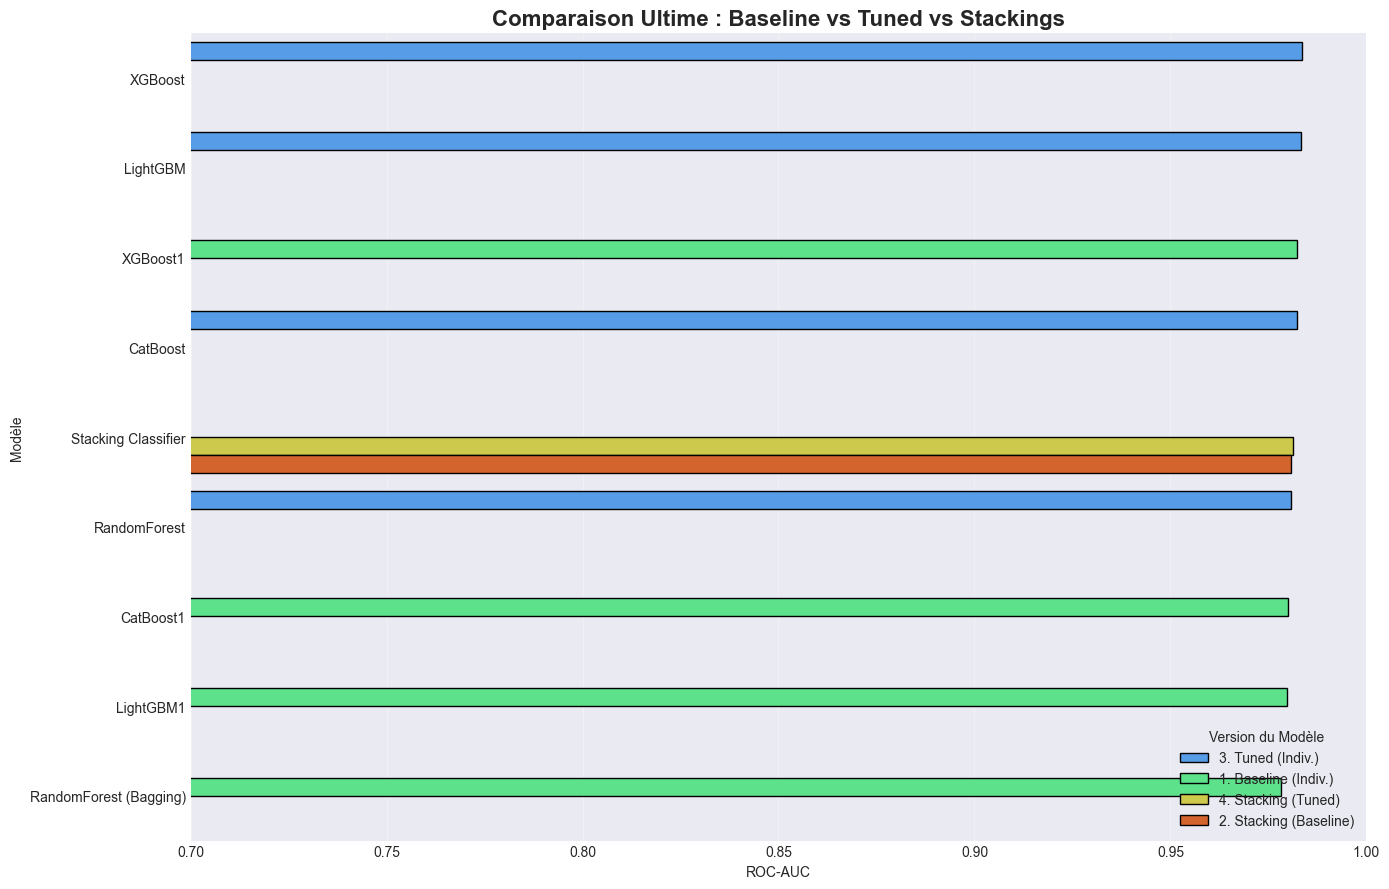

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

comparison_data = []

# =========================================================
# 1. MODÈLES INDIVIDUELS (BASELINE)
# =========================================================
if 'df_scores' in locals():
    for index, row in df_scores.iterrows():
        comparison_data.append({
            'Modèle': row['Modèle'],
            'Version': '1. Baseline (Indiv.)',
            'ROC-AUC': row['ROC-AUC'],
            'F1-Score': row['F1-Score'],
            'Accuracy': row['Accuracy']
        })

# =========================================================
# 2. STACKING (BASELINE) - Sans Tuning
# =========================================================
# On cherche vos variables (j'inclus les noms standards que nous avons utilisés)
auc_base = locals().get('stack_base_auc', 0)
f1_base = locals().get('stack_base_f1', 0)
acc_base = locals().get('stack_base_acc', 0)

if auc_base > 0:
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '2. Stacking (Baseline)',
        'ROC-AUC': auc_base,
        'F1-Score': f1_base,
        'Accuracy': acc_base
    })
else:
    print("⚠️ Stacking Baseline non détecté en mémoire.")

# =========================================================
# 3. MODÈLES INDIVIDUELS (TUNED)
# =========================================================
if 'df_final_scores' in locals():
    for index, row in df_final_scores.iterrows():
        comparison_data.append({
            'Modèle': row['Modèle'],
            'Version': '3. Tuned (Indiv.)',
            'ROC-AUC': row['ROC-AUC Test'],
            'F1-Score': row['F1-Score Test'],
            'Accuracy': row['Accuracy Test']
        })

# =========================================================
# 4. STACKING (TUNED) - Avec Tuning
# =========================================================
# On cherche 'stack_tuned_auc' ou 'stack_auc' (ancien nom possible)
auc_tuned = locals().get('stack_tuned_auc', locals().get('stack_auc', 0))
f1_tuned = locals().get('stack_tuned_f1', locals().get('stack_f1', 0))
acc_tuned = locals().get('stack_tuned_acc', locals().get('stack_acc', 0))

if auc_tuned > 0:
    comparison_data.append({
        'Modèle': "Stacking Classifier",
        'Version': '4. Stacking (Tuned)',
        'ROC-AUC': auc_tuned,
        'F1-Score': f1_tuned,
        'Accuracy': acc_tuned
    })
else:
    print("⚠️ Stacking Tuned non détecté en mémoire.")

# =========================================================
# AFFICHAGE ET GRAPHIQUE
# =========================================================
if comparison_data:
    df_global = pd.DataFrame(comparison_data)
    df_global = df_global.sort_values('ROC-AUC', ascending=False).reset_index(drop=True)

    print(f"\n{'='*80}")
    print("🏆 CLASSEMENT FINAL COMPLET (4 GROUPES)")
    print(f"{'='*80}\n")
    
    # Affichage sécurisé (sans style si erreur)
    try:
        styled = df_global.style.background_gradient(cmap='RdYlGn', subset=['ROC-AUC', 'F1-Score'])
        display(styled)
    except:
        display(df_global)

    # Graphique
    plt.figure(figsize=(14, 9))
    sns.barplot(
        data=df_global,
        y='Modèle',
        x='ROC-AUC',
        hue='Version',
        palette='turbo',
        edgecolor='black'
    )
    plt.title('Comparaison Ultime : Baseline vs Tuned vs Stackings', fontsize=16, fontweight='bold')
    plt.xlim(0.7, 1.0) # Zoom sur la performance
    plt.legend(title='Version du Modèle', loc='lower right')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Aucune donnée trouvée pour la comparaison.")